In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix, \
    recall_score, precision_score, f1_score, roc_auc_score
from IPython.display import display
from sklearn.impute import SimpleImputer

%matplotlib inline
sns.set(style="ticks", font_scale=1.1)

In [28]:
forecast_files = range(1, 7)
daily_peaks = None

for n in forecast_files:
    file_path = f"IESO-Ontario Demand 2022-2025 {n} day ahead.csv"
    df_temp = pd.read_csv(file_path)
    # Remove unnamed columns that may appear in the CSV
    df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
    # Create datetime and date columns
    df_temp['datetime'] = pd.to_datetime(df_temp['Date'] + ' ' + df_temp['Time'], dayfirst=True, errors='coerce')
    df_temp['date'] = df_temp['datetime'].dt.date
    # Aggregate to find daily maximum (peak) values for each predictor and the actual load
    agg = df_temp.groupby('date').agg({
        'ECA: IESO-Ontario Demand Historic Forecast': 'max',
        'RTO: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Actual': 'max'
    })
    # Rename prediction columns to reflect the forecast horizon. The actual peak is kept only for the 1‑day horizon.
    rename_map = {
        'ECA: IESO-Ontario Demand Historic Forecast': f'ECA_peak_{n}d',
        'RTO: IESO-Ontario Demand Historic Forecast': f'RTO_peak_{n}d',
        'TESLA: IESO-Ontario Demand Historic Forecast': f'TESLA_pred_peak_{n}d'
    }
    agg = agg.rename(columns=rename_map)
    if n == 1:
        agg = agg.rename(columns={'TESLA: IESO-Ontario Demand Actual': 'actual_peak'})
    else:
        # Drop the actual column for horizons other than 1 day ahead
        agg = agg.drop(columns=['TESLA: IESO-Ontario Demand Actual'])
    # Merge the current horizon's daily peaks into the master DataFrame
    if daily_peaks is None:
        daily_peaks = agg
    else:
        daily_peaks = daily_peaks.join(agg, how='outer')

# Backfill any missing actual_peak values using neighbouring days
if 'actual_peak' in daily_peaks.columns:
    daily_peaks['actual_peak'] = daily_peaks['actual_peak'].ffill().bfill()
# Derive year and month from the index for downstream analysis
idx = pd.to_datetime(daily_peaks.index)
daily_peaks['year'] = idx.year
daily_peaks['month'] = idx.month

daily_peaks.head()

,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d,actual_peak,ECA_peak_2d,RTO_peak_2d,TESLA_pred_peak_2d,ECA_peak_3d,RTO_peak_3d,TESLA_pred_peak_3d,...,RTO_peak_4d,TESLA_pred_peak_4d,ECA_peak_5d,RTO_peak_5d,TESLA_pred_peak_5d,ECA_peak_6d,RTO_peak_6d,TESLA_pred_peak_6d,year,month
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,17310.5,17025.45,17025.45,16954.95,17475.6,17043.95,17043.95,17463.6,17010.40,17010.40,...,17010.40,17010.40,17463.6,17010.40,17010.40,17840.9,17581.75,17581.75,2022,1
2022-01-02,18871.0,19026.75,19026.75,18923.03,18786.2,18964.95,18964.95,18799.3,18996.50,18996.50,...,18996.50,18996.50,19558.7,19031.80,19031.80,19456.6,19394.10,19394.10,2022,1
2022-01-03,20130.1,20323.15,20323.15,20051.29,19924.1,20147.70,20147.70,19919.8,20304.15,20304.15,...,20304.15,20304.15,18846.3,19064.90,19064.90,18811.4,19031.55,19031.55,2022,1
2022-01-04,19548.8,19115.85,19115.85,19408.90,19387.7,19085.10,19085.10,19354.1,18939.90,18939.90,...,18939.90,18939.90,16516.5,16749.45,16749.45,16364.1,16493.05,16493.05,2022,1
2022-01-05,19494.2,19147.90,19147.90,19338.73,19794.5,19100.40,19100.40,19751.8,19011.60,19011.60,...,19011.60,19011.60,14541.7,14614.20,14614.20,14533.9,14699.70,14699.70,2022,1


In [29]:
info = df_temp.info()
info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29543 entries, 0 to 29542
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Date                                          29543 non-null  object        
 1   Time                                          29543 non-null  object        
 2   ECA: IESO-Ontario Demand Historic Forecast    29543 non-null  float64       
 3   RTO: IESO-Ontario Demand Historic Forecast    29543 non-null  float64       
 4   TESLA: IESO-Ontario Demand Historic Forecast  29543 non-null  float64       
 5   TESLA: IESO-Ontario Demand Actual             29336 non-null  float64       
 6   datetime                                      11316 non-null  datetime64[ns]
 7   date                                          11316 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.8+ MB


In [30]:
# Descriptive statistics
stats = daily_peaks[[
    'actual_peak',
    'ECA_peak_1d',
    'RTO_peak_1d',
    'TESLA_pred_peak_1d'
]].describe()
stats

,actual_peak,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d
count,1266.000000,1231.000000,1231.000000,1231.000000
mean,18091.403049,17848.719659,18085.877701,18085.877701
std,1867.357262,1621.963236,1848.116273,1848.116273
min,13303.840000,13631.700000,13696.100000,13696.100000
25%,16590.365000,16557.250000,16593.300000,16593.300000
50%,18047.920000,17898.700000,18092.800000,18092.800000
75%,19520.735000,19257.050000,19437.450000,19437.450000
max,23851.820000,21132.100000,24339.550000,24339.550000


In [31]:
# Check for missing values
missing = daily_peaks.isna().sum()
missing

ECA_peak_1d            35
RTO_peak_1d            35
TESLA_pred_peak_1d     35
actual_peak             0
ECA_peak_2d            35
RTO_peak_2d            35
TESLA_pred_peak_2d     35
ECA_peak_3d            35
RTO_peak_3d            35
TESLA_pred_peak_3d     35
ECA_peak_4d            35
RTO_peak_4d            35
TESLA_pred_peak_4d     35
ECA_peak_5d           774
RTO_peak_5d           774
TESLA_pred_peak_5d    774
ECA_peak_6d           774
RTO_peak_6d           774
TESLA_pred_peak_6d    774
year                    0
month                   0
dtype: int64

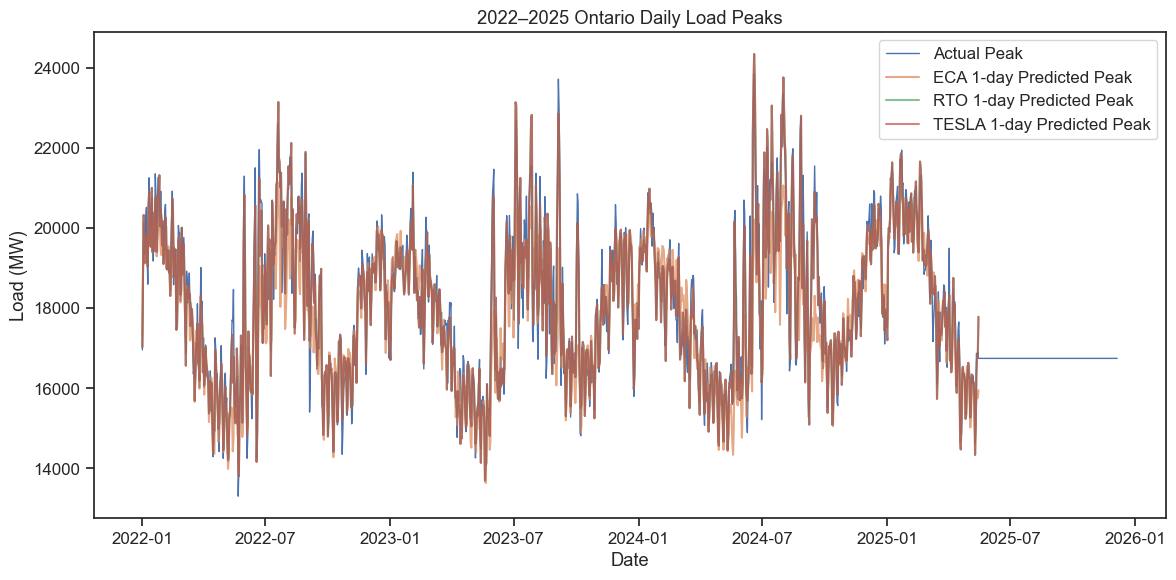

In [32]:
# Draw the trends of actual peaks and predicted peaks in chronological order
plt.figure(figsize=(12, 6))
plt.plot(daily_peaks.index, daily_peaks['actual_peak'], label='Actual Peak', linewidth=1.0)
plt.plot(daily_peaks.index, daily_peaks['ECA_peak_1d'], label='ECA 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['RTO_peak_1d'], label='RTO 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['TESLA_pred_peak_1d'], label='TESLA 1-day Predicted Peak', alpha=0.7)
plt.title('2022–2025 Ontario Daily Load Peaks')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

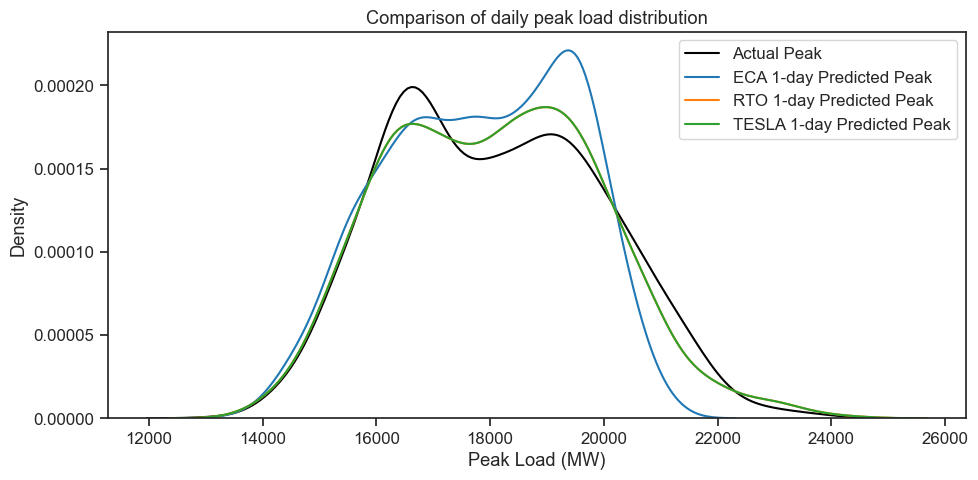

In [33]:
# Draw the distribution curve between the actual peak and the predicted peak
plt.figure(figsize=(10, 5))
for col, color, label in zip(['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d'],
                             ['black', 'tab:blue', 'tab:orange', 'tab:green'],
                             ['Actual Peak', 'ECA 1-day Predicted Peak', 'RTO 1-day Predicted Peak',
                              'TESLA 1-day Predicted Peak']):
    # Use KDE curves to display the distribution, do not enable fill to avoid dtype problems
    sns.kdeplot(daily_peaks[col], label=label, color=color, linewidth=1.5)
plt.title('Comparison of daily peak load distribution')
plt.xlabel('Peak Load (MW)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

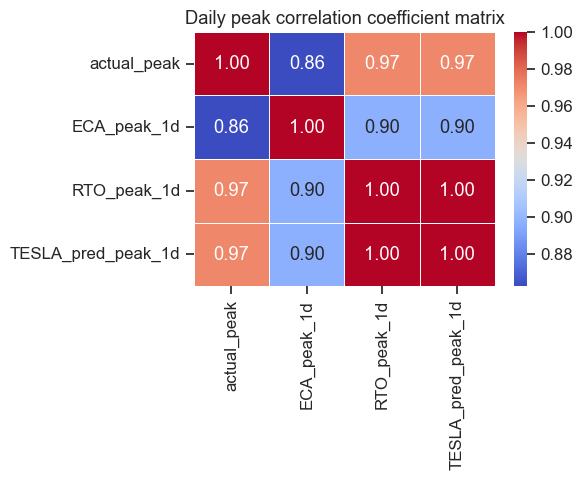

In [34]:
# Calculate the correlation coefficient matrix and draw the heat map
corr = daily_peaks[['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Daily peak correlation coefficient matrix')
plt.tight_layout()
plt.show()

In [35]:
# Sort from high to low by the actual peaks of each year, select the top 4 dates as CP days
daily_peaks['is_CP'] = 0
for yr in daily_peaks['year'].unique():
    subset = daily_peaks[daily_peaks['year'] == yr]
    # If the record in a certain year is less than 4 days, all will be selected
    top_k = subset.nlargest(4, 'actual_peak').index
    daily_peaks.loc[top_k, 'is_CP'] = 1

# Display the CP daily list and corresponding peak values for each year
cp_days = daily_peaks[daily_peaks['is_CP'] == 1][['actual_peak', 'year']]
cp_days.sort_values(['year', 'actual_peak'], ascending=[True, False])

,actual_peak,year
date,,
2022-07-19,22607.37,2022
2022-06-22,21953.98,2022
2022-08-29,21870.74,2022
2022-07-20,21850.29,2022
2023-09-05,23712.73,2023
2023-09-06,22965.69,2023
2023-07-05,22685.82,2023
2023-07-06,21881.67,2023
2024-06-19,23851.82,2024


In [36]:
selected_feature = 'ECA'  # modify this variable to pick a single forecast model

# Determine the feature columns based on the selection above.
feature_cols = []
if selected_feature == 'ECA':
    feature_cols = [f'ECA_peak_{n}d' for n in forecast_files]
elif selected_feature == 'RTO':
    feature_cols = [f'RTO_peak_{n}d' for n in forecast_files]
elif selected_feature == 'TESLA':
    feature_cols = [f'TESLA_pred_peak_{n}d' for n in forecast_files]
else:
    # Use all models and all horizons as inputs
    for base in ['ECA_peak', 'RTO_peak', 'TESLA_pred_peak']:
        for n in forecast_files:
            feature_cols.append(f'{base}_{n}d')

# Extract features and labels
features = daily_peaks[feature_cols]
labels = daily_peaks['is_CP']
years = daily_peaks['year']
months = daily_peaks['month']

features = features.fillna(features.mean())

# Define the separation year for training/testing split and analysis window
separation = 2024
start_month = 6
end_month = 9

# 2022–2024 as the training set and 2025 as the test set
X_train = features[years < separation]
y_train = labels[years < separation]
X_test = features[years >= separation]
y_test = labels[years >= separation]

X_train_scaled = X_train
X_test_scaled = X_test


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def prepare_ts_data(daily_peaks, feature_cols, target_col, seq_length=30):
    ts_data = daily_peaks.sort_index()

    main_feature = ts_data['actual_peak'].values.reshape(-1, 1)

    X_seq, y_seq = create_sequences(main_feature.flatten(), seq_length)

    labels = ts_data['is_CP'].values[seq_length:]

    return X_seq, labels


class ARIMAClassifier:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model = None
        self.threshold = 0.5

    def fit(self, X, y):
        try:
            ts_data = daily_peaks.sort_index()
            train_mask = ts_data['year'] < separation
            train_series = ts_data.loc[train_mask, 'actual_peak']

            train_series.index.freq = 'D'

            self.model = ARIMA(train_series, order=self.order)
            self.fitted_model = self.model.fit()

            train_labels = ts_data.loc[train_mask, 'is_CP']
            cp_values = train_series[train_labels == 1]
            if len(cp_values) > 0:
                self.threshold = np.percentile(train_series, 95)
        except:
            self.fitted_model = None

    def predict_proba(self, X):
        if self.fitted_model is None:
            return np.random.random((len(X), 2))

        try:
            ts_data = daily_peaks.sort_index()
            test_mask = ts_data['year'] >= separation
            test_data = ts_data.loc[test_mask]

            forecast = self.fitted_model.forecast(steps=len(test_data))

            probs = (forecast - forecast.min()) / (forecast.max() - forecast.min() + 1e-8)

            prob_array = np.column_stack([1 - probs, probs])
            return prob_array
        except:
            return np.random.random((len(X), 2))


class LSTMClassifier:
    def __init__(self, seq_length=30, lstm_units=50):
        self.seq_length = seq_length
        self.lstm_units = lstm_units
        self.model = None
        self.scaler = None

    def fit(self, X, y):
        X_seq, y_seq = prepare_ts_data(daily_peaks, feature_cols, 'is_CP', self.seq_length)

        train_size = int(len(X_seq) * 0.8)
        X_train_seq = X_seq[:train_size]
        y_train_seq = y_seq[:train_size]

        if len(X_train_seq) == 0:
            return

        self.model = Sequential([
            Input(shape=(self.seq_length, 1)),
            LSTM(self.lstm_units, return_sequences=True),
            Dropout(0.2),
            LSTM(self.lstm_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

        try:
            self.model.fit(X_train_seq, y_train_seq,
                           epochs=50,
                           batch_size=32,
                           verbose=0,
                           callbacks=[early_stopping])
        except:
            pass

    def predict_proba(self, X):
        if self.model is None:
            return np.random.random((len(X), 2))

        try:
            X_seq, _, _ = prepare_ts_data(daily_peaks, feature_cols, 'is_CP', self.seq_length)

            train_size = int(len(X_seq) * 0.8)
            X_test_seq = X_seq[train_size:]

            if len(X_test_seq) == 0:
                return np.random.random((len(X), 2))

            pred_probs = self.model.predict(X_test_seq, verbose=0).flatten()

            if len(pred_probs) != len(X):
                pred_probs = np.resize(pred_probs, len(X))

            prob_array = np.column_stack([1 - pred_probs, pred_probs])
            return prob_array
        except:
            return np.random.random((len(X), 2))


class GRUClassifier:
    def __init__(self, seq_length=30, gru_units=50):
        self.seq_length = seq_length
        self.gru_units = gru_units
        self.model = None
        self.scaler = None

    def fit(self, X, y):
        X_seq, y_seq = prepare_ts_data(daily_peaks, feature_cols, 'is_CP', self.seq_length)

        train_size = int(len(X_seq) * 0.8)
        X_train_seq = X_seq[:train_size]
        y_train_seq = y_seq[:train_size]

        if len(X_train_seq) == 0:
            return

        self.model = Sequential([
            Input(shape=(self.seq_length, 1)),
            GRU(self.gru_units, return_sequences=True),
            Dropout(0.2),
            GRU(self.gru_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

        try:
            self.model.fit(X_train_seq, y_train_seq,
                           epochs=50,
                           batch_size=32,
                           verbose=0,
                           callbacks=[early_stopping])
        except:
            pass

    def predict_proba(self, X):
        if self.model is None:
            return np.random.random((len(X), 2))

        try:
            X_seq, _, _ = prepare_ts_data(daily_peaks, feature_cols, 'is_CP', self.seq_length)

            train_size = int(len(X_seq) * 0.8)
            X_test_seq = X_seq[train_size:]

            if len(X_test_seq) == 0:
                return np.random.random((len(X), 2))

            pred_probs = self.model.predict(X_test_seq, verbose=0).flatten()

            if len(pred_probs) != len(X):
                pred_probs = np.resize(pred_probs, len(X))

            prob_array = np.column_stack([1 - pred_probs, pred_probs])
            return prob_array
        except:
            return np.random.random((len(X), 2))


In [37]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=0, class_weight="balanced"),
    # Extra Trees: extremely randomized trees that further randomise split points and use averaging for prediction.
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=0, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    # Hist Gradient Boosting: gradient boosting implementation using histogram-based binning for efficiency.
    "Hist Gradient Boosting": HistGradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    # GaussianNB: Gaussian naive Bayes classifier assuming independent normal distributions for each feature.
    "GaussianNB": GaussianNB(),
    # LDA: linear discriminant analysis classifier that assumes multivariate normal classes with shared covariance.
    "LDA": LinearDiscriminantAnalysis(),
    # QDA: quadratic discriminant analysis allowing each class to have its own covariance matrix.
    "QDA": QuadraticDiscriminantAnalysis(reg_param=0.1),
    # MLP: multi-layer perceptron neural network classifier with one hidden layer.
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=0),
    "ARIMA": ARIMAClassifier(order=(2, 1, 2)),
    "LSTM": LSTMClassifier(seq_length=30, lstm_units=50),
    "GRU": GRUClassifier(seq_length=30, gru_units=50),
}

results = []
proba_dict = {}

In [38]:
THRESH_PCTL = 0.95  # percentile threshold for determining high-load (CP) days
THRESH_FACTOR = 4  # weight multiplier applied to high-load days


def wei_classification(y_true, prob, threshold_percentile=THRESH_PCTL, weight_factor=THRESH_FACTOR):
    y_true_array = np.array(y_true)
    # Determine threshold based on the specified percentile of the labels (for binary labels this is typically 1)
    threshold = np.quantile(y_true_array, threshold_percentile)
    # Assign weights: use a higher weight when the actual label meets or exceeds the threshold
    weights = np.where(y_true_array >= threshold, weight_factor, 1.0)
    weighted_error = np.abs(prob - y_true_array)
    wei = (weights * weighted_error).sum() / weights.sum()
    total_weighted_error = (weights * weighted_error).sum()
    if total_weighted_error > 0:
        share = (weights[y_true_array >= threshold] * weighted_error[
            y_true_array >= threshold]).sum() / total_weighted_error
    else:
        share = 0.0
    return wei, share

C:\Users\Katuz\anaconda3\envs\AI\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Katuz\anaconda3\envs\AI\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Katuz\anaconda3\envs\AI\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Katuz\anaconda3\envs\AI\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Comparison of evaluation indicators of each model:


,Model,Recall,Precision,F1,AUC,Recall@4,Precision@4,WEI,WEI_Share
0,Logistic Regression,0.000,0.000000,0.000000,0.992188,0.125,0.25,0.018320,1.0
8,SVM (Linear),0.000,0.000000,0.000000,0.989583,0.125,0.25,0.016979,1.0
11,LDA,0.125,0.166667,0.142857,0.973011,0.125,0.25,0.022315,1.0
9,SVM (RBF),0.000,0.000000,0.000000,0.962831,0.250,0.50,0.027378,1.0
3,Extra Trees,0.750,0.214286,0.333333,0.962831,0.500,1.00,0.047388,1.0
4,Gradient Boosting,0.625,0.312500,0.416667,0.955966,0.000,0.00,0.030339,1.0
2,Random Forest,0.000,0.000000,0.000000,0.953243,0.125,0.25,0.043424,1.0
6,Hist Gradient Boosting,0.125,0.500000,0.200000,0.950876,0.125,0.25,0.043022,1.0
5,AdaBoost,0.625,0.147059,0.238095,0.947206,0.000,0.00,0.318515,1.0
12,QDA,0.125,0.250000,0.166667,0.944366,0.125,0.25,0.019810,1.0


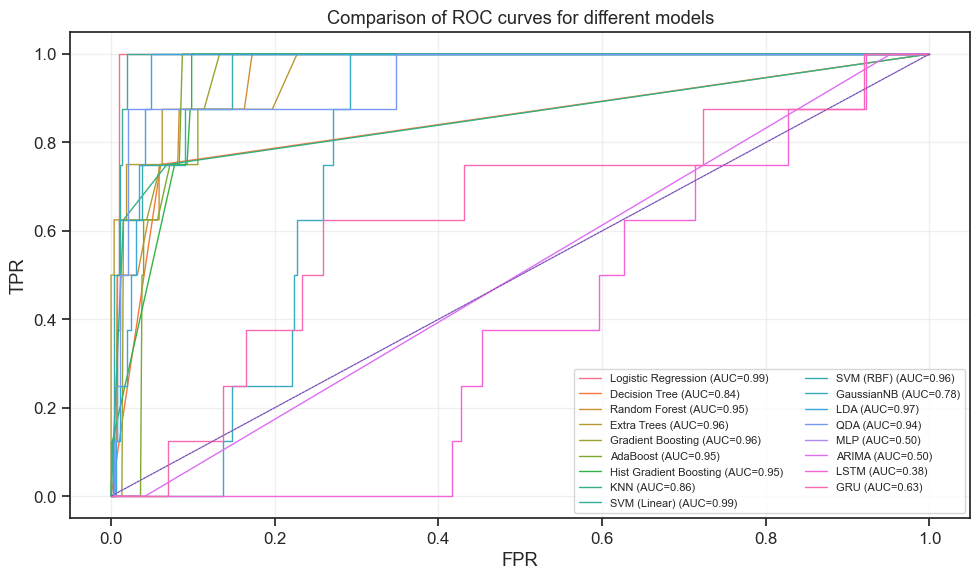

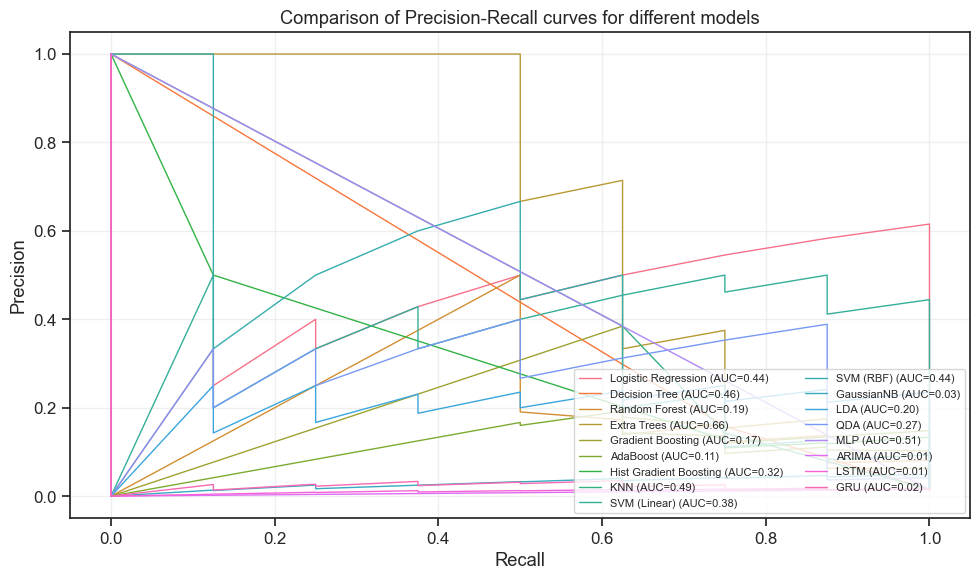

In [39]:
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)
    # Get prediction probability or decision function
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test_scaled)
        if getattr(prob, "ndim", 1) == 2:
            prob = prob[:, 1]
    else:
        score = model.decision_function(X_test_scaled)
        # Scaling the decision function to [0,1] as a probability approximation
        prob = (score - score.min()) / (score.max() - score.min() + 1e-8)
    pred = (prob >= 0.5).astype(int)
    # Calculate indicators
    rec = recall_score(y_test, pred, zero_division=0)
    prec = precision_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    auc_score = roc_auc_score(y_test, prob)
    # Ranking hit rate
    ranking = pd.DataFrame({"prob": prob, "actual": y_test.values}).sort_values("prob", ascending=False).reset_index(
        drop=True)
    top4 = ranking.head(4)
    hits = int(top4["actual"].sum())
    recall_at4 = hits / max(int(y_test.sum()), 1)
    precision_at4 = hits / 4
    wei_val, wei_share_val = wei_classification(y_test.values, prob)
    results.append({
        "Model": name,
        "Recall": rec,
        "Precision": prec,
        "F1": f1,
        "AUC": auc_score,
        "Recall@4": recall_at4,
        "Precision@4": precision_at4,
        "WEI": wei_val,
        "WEI_Share": wei_share_val,
    })
    proba_dict[name] = prob

# Summary of results
results_df = pd.DataFrame(results).sort_values("AUC", ascending=False)
print("Comparison of evaluation indicators of each model:")
display(results_df)

# Draw the ROC curves for each model
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(models))

for i, name in enumerate(models.keys()):
    prob = proba_dict[name]
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})", lw=1.0, color=colors[i])
plt.plot([0, 1], [0, 1], "k--", lw=0.5, alpha=0.6)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparison of ROC curves for different models")
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, name in enumerate(models.keys()):
    prob = proba_dict[name]
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, label=f"{name} (AUC={pr_auc:.2f})", lw=1.0, color=colors[i])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Comparison of Precision-Recall curves for different models")
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
selected_model = "Extra Trees"  # Modify this variable to select the model for evaluation

dates_index = pd.to_datetime(daily_peaks.index)
mask = (daily_peaks["year"] >= separation) & (dates_index.month >= start_month) & (dates_index.month <= end_month)
period_data = daily_peaks.loc[mask].copy()

if not period_data.empty:
    period_features = period_data[feature_cols]
    period_features = period_features.fillna(features.mean())
    # X_period_scaled = scaler.transform(period_features)
    X_period_scaled = period_features

    # Calculate probability for the specific model
    model = models[selected_model]
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X_period_scaled)
        if getattr(p, "ndim", 1) == 2:
            p = p[:, 1]
    else:
        s = model.decision_function(X_period_scaled)
        p = (s - s.min()) / (s.max() - s.min() + 1e-8)

    period_data[f"{selected_model}_prob"] = p

    # Shows the first 4 possible CP days predicted by each model within this interval
    for year in sorted(period_data['year'].unique()):
        year_data = period_data[period_data['year'] == year]
        print(f"\n=== {year} results ===")

        for month in sorted(year_data['month'].unique()):
            month_data = year_data[year_data['month'] == month]
            if not month_data.empty:
                sub = month_data[[f"{selected_model}_prob", "actual_peak", "is_CP"]].sort_values(
                    f"{selected_model}_prob", ascending=False).head(4)

                print(f"\n{year}-{month} - {selected_model}")
                display(sub)

                hits = int(sub["is_CP"].sum())
                total_cp_days = int(month_data["is_CP"].sum())
                print(f"Number of hits real CP days:{hits}/4")
                print(f"Total number of actual CP days for the month: {total_cp_days}")
                if total_cp_days > 0:
                    recall = hits / total_cp_days
                    print(f"Recall rate: {recall:.2%}")
                precision = hits / 4
                print(f"Accuracy: {precision:.2%}")
else:
    print(f"No data available for the period {separation}-{start_month}-{end_month}.")


=== 2024 results ===

2024-6 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2024-06-20,0.645,22485.78,0
2024-06-19,0.565,23851.82,1
2024-06-21,0.035,20941.61,0
2024-06-23,0.015,19076.84,0


Number of hits real CP days:1/4
Total number of actual CP days for the month: 2
Recall rate: 50.00%
Accuracy: 25.00%

2024-7 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2024-07-31,0.710,23355.86,1
2024-07-30,0.600,22371.08,0
2024-07-29,0.550,22244.97,0
2024-07-15,0.515,21637.19,0


Number of hits real CP days:1/4
Total number of actual CP days for the month: 1
Recall rate: 100.00%
Accuracy: 25.00%

2024-8 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2024-08-05,0.495,20269.79,0
2024-08-01,0.305,23179.24,1
2024-08-03,0.250,21899.00,0
2024-08-06,0.145,17854.22,0


Number of hits real CP days:1/4
Total number of actual CP days for the month: 1
Recall rate: 100.00%
Accuracy: 25.00%

2024-9 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2024-09-06,0.010,18005.31,0
2024-09-05,0.005,19899.78,0
2024-09-02,0.000,16181.70,0
2024-09-01,0.000,17171.41,0


Number of hits real CP days:0/4
Total number of actual CP days for the month: 0
Accuracy: 0.00%

=== 2025 results ===

2025-6 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2025-06-05,0.020,16742.65,0
2025-06-04,0.015,16742.65,0
2025-06-01,0.000,16742.65,0
2025-06-03,0.000,16742.65,0


Number of hits real CP days:0/4
Total number of actual CP days for the month: 0
Accuracy: 0.00%

2025-7 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2025-07-05,0.015,16742.65,0
2025-07-01,0.000,16742.65,0
2025-07-02,0.000,16742.65,0
2025-07-03,0.000,16742.65,0


Number of hits real CP days:0/4
Total number of actual CP days for the month: 0
Accuracy: 0.00%

2025-8 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2025-08-05,0.015,16742.65,0
2025-08-01,0.000,16742.65,0
2025-08-02,0.000,16742.65,0
2025-08-03,0.000,16742.65,0


Number of hits real CP days:0/4
Total number of actual CP days for the month: 0
Accuracy: 0.00%

2025-9 - Extra Trees


,Extra Trees_prob,actual_peak,is_CP
date,,,
2025-09-05,0.045,16742.65,0
2025-09-01,0.000,16742.65,0
2025-09-02,0.000,16742.65,0
2025-09-03,0.000,16742.65,0


Number of hits real CP days:0/4
Total number of actual CP days for the month: 0
Accuracy: 0.00%
